In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os #a library to interact with the file system
import cv2 #a library to access the images
from PIL import Image

import rasterio #a library that facilitates working with raster data
from rasterio.enums import Resampling
from rasterio.plot import reshape_as_image, show
import rasterio.mask
from rasterio.features import rasterize
from rasterio.plot import show
from rasterio import features
from rasterio.features import shapes
from sklearn.preprocessing import MinMaxScaler
from skimage.io import imshow
# from patchify import patchify, unpatchify #to patchifly large images into smaller patches
from matplotlib import pyplot as plt
import random
import tensorflow as tf

import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Reshape, Activation
from keras.layers import AveragePooling2D, concatenate, BatchNormalization, Dropout, Lambda, SpatialDropout2D
from keras import backend as K

import segmentation_models as sm
import glob
import albumentations as A

import shapely
from shapely.geometry import Point, Polygon
from shapely.ops import transform
from shapely.geometry import Polygon, MultiPolygon

import matplotlib
import matplotlib.font_manager as fm
import geopandas as gpd
import folium
import pyproj
import json
import shutil
# from gradient_accumulator import GradientAccumulateModel
from keras.models import load_model
from datetime import datetime
import matplotlib.ticker as ticker
time = datetime.now().strftime("%Y%m%d")

from tensorflow.keras.applications import ResNet50
from keras.metrics import MeanIoU

fe = fm.FontEntry(
    fname='./BookAntiquaFont.ttf',
    name='Book Antiqua')
fm.fontManager.ttflist.insert(0, fe)
matplotlib.rcParams['font.family'] = fe.name
matplotlib.rcParams.update({'font.size': 16})

Segmentation Models: using `keras` framework.


/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [13]:
def load_geotiff_image(file_path):
    """
    A function that uses the rasterio library to read a GeoTIFF image and convert it into a numpy array
    """
    scale_factor = 0.5
    
    with rasterio.open(file_path) as dataset:

    # resample data to target shape
        data = dataset.read(out_shape=(dataset.count, int(dataset.height * scale_factor), int(dataset.width * scale_factor)), resampling=Resampling.bilinear)

    # scale image transform
        transform = dataset.transform * dataset.transform.scale((dataset.width / data.shape[-1]),(dataset.height / data.shape[-2]))
    
    #rearrage the order of the image channel from first to last
    image = np.moveaxis(data, 0, -1)
    return image

def normalise(input_image):
    n_image = (input_image - input_image.min()) / (input_image.max()- input_image.min())
    return n_image

In [14]:
directory_path = '/kaggle/input/oilspill-dataset-utm'
dataset = 'oilspill_dataset'

image_dataset = []
for idx in range(1,55):
    image = load_geotiff_image(f'{directory_path}/{dataset}/train/images/image_{idx}.tif')
    image = np.array(image)
    image[np.isnan(image)] = 0
    # Create a masked array where values greater than -1 are masked
#     masked_array = np.ma.masked_greater(image, -1.0)
    # Calculate median of the unmasked values
#     image[(image >= -1.0)] = np.ma.median(masked_array)
    image = normalise(image)
    wind = load_geotiff_image(f'{directory_path}/{dataset}/train/wind/wind_{idx}.tif')
    wind = normalise(wind)
    #rasterio will read the wind images upside down so we have to flip the vetrical axis
    wind = np.flip(wind[:], axis=0)
    # Stack the two bands together
    input_image_2ch = np.dstack((image, wind))
    image_dataset.append(input_image_2ch)

mask_dataset = []
for idx in range(1,55):
    mask = load_geotiff_image(f'{directory_path}/{dataset}/train/masks/mask_{idx}.tif')
    mask_dataset.append(mask)

val_image_dataset = []
for idx in range(1,14):
    val_image = load_geotiff_image(f'{directory_path}/{dataset}/validation/images/image_{idx}.tif')
    val_image = np.array(val_image)
    val_image[np.isnan(val_image)] = 0
#     val_masked_array = np.ma.masked_greater(val_image, -1.0)
#     val_image[(val_image >= -1.0)] = np.ma.median(val_masked_array)
    val_image = normalise(val_image)
    val_wind = load_geotiff_image(f'{directory_path}/{dataset}/validation/wind/wind_{idx}.tif')
    val_wind = normalise(val_wind)
    #rasterio will read the wind images upside down so we have to flip the vetrical axis
    val_wind = np.flip(val_wind[:], axis=0)
    # Stack the two bands together
    val_input_image_2ch = np.dstack((val_image, val_wind))   
    val_image_dataset.append(val_input_image_2ch)
    
val_mask_dataset = []
for idx in range(1,14):
    val_mask = load_geotiff_image(f'{directory_path}/{dataset}/validation/masks/mask_{idx}.tif')
    val_mask_dataset.append(val_mask)

In [15]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
val_image_dataset = np.array(val_image_dataset)
val_mask_dataset = np.array(val_mask_dataset)

print(image_dataset.shape)
print(mask_dataset.shape)
print(val_image_dataset.shape)
print(val_mask_dataset.shape)

image_height = image_dataset.shape[1]
image_width = image_dataset.shape[2]
image_channels = image_dataset.shape[3]
total_classes = mask_dataset.shape[3]

(54, 512, 512, 2)
(54, 512, 512, 1)
(13, 512, 512, 2)
(13, 512, 512, 1)


In [16]:
h_flipped_image_dataset = []
h_flipped_mask_dataset = []

for x in range(len(image_dataset)):
    aug = A.HorizontalFlip(p=1)
    augmented = aug(image=image_dataset[x], mask=mask_dataset[x])
    image_h_flipped = augmented['image']
    mask_h_flipped = augmented['mask']
    h_flipped_image_dataset.append(image_h_flipped)
    h_flipped_mask_dataset.append(mask_h_flipped)

In [17]:
v_flipped_image_dataset = []
v_flipped_mask_dataset = []

for x in range(len(image_dataset)):
    aug = A.VerticalFlip(p=1)
    augmented = aug(image=image_dataset[x], mask=mask_dataset[x])
    image_v_flipped = augmented['image']
    mask_v_flipped = augmented['mask']
    v_flipped_image_dataset.append(image_v_flipped)
    v_flipped_mask_dataset.append(mask_v_flipped)

In [18]:
rot90_image_dataset = []
rot90_mask_dataset = []

for x in range(len(image_dataset)):
    aug = A.RandomRotate90(p=1)
    augmented = aug(image=image_dataset[x], mask=mask_dataset[x])
    image_rot90 = augmented['image']
    mask_rot90 = augmented['mask']
    rot90_image_dataset.append(image_rot90)
    rot90_mask_dataset.append(mask_rot90)

In [19]:
transposed_image_dataset = []
transposed_mask_dataset = []

for x in range(len(image_dataset)):
    aug = A.Transpose(p=1)
    augmented = aug(image=image_dataset[x], mask=mask_dataset[x])
    image_transposed = augmented['image']
    mask_transposed = augmented['mask']
    transposed_image_dataset.append(image_transposed)
    transposed_mask_dataset.append(mask_transposed)

In [20]:
augmented_image_dataset = np.concatenate((image_dataset,
                                          h_flipped_image_dataset,
                                          v_flipped_image_dataset,
                                          rot90_image_dataset,
                                          transposed_image_dataset), axis=0)

augmented_mask_dataset = np.concatenate((mask_dataset,
                                         h_flipped_mask_dataset,
                                         v_flipped_mask_dataset,
                                         rot90_mask_dataset,
                                         transposed_mask_dataset), axis=0)

In [21]:
image_dataset_1ch = image_dataset[:,:,:,0]
val_image_dataset_1ch = val_image_dataset[:,:,:,0]
image_dataset_1ch = np.expand_dims(image_dataset_1ch, axis=-1)
val_image_dataset_1ch = np.expand_dims(val_image_dataset_1ch, axis=-1)
image_channels_1ch = image_dataset_1ch.shape[3]

# Converting the input to tensor
image_dataset_tf = tf.convert_to_tensor(image_dataset)
val_image_dataset_tf = tf.convert_to_tensor(val_image_dataset)
image_dataset_1ch_tf = tf.convert_to_tensor(image_dataset_1ch)
val_image_dataset_1ch_tf =  tf.convert_to_tensor(val_image_dataset_1ch)
mask_dataset_tf = tf.cast(mask_dataset, dtype=tf.float32)
val_mask_dataset_tf = tf.cast(val_mask_dataset, dtype=tf.float32)

augmented_image_dataset_1ch = augmented_image_dataset[:,:,:,0]
val_image_dataset_1ch = val_image_dataset[:,:,:,0]

augmented_image_dataset_1ch = np.expand_dims(augmented_image_dataset_1ch, axis=-1)
val_image_dataset_1ch = np.expand_dims(val_image_dataset_1ch, axis=-1)

image_channels_1ch = image_dataset_1ch.shape[3]

# Converting the input to tensor
augmented_image_dataset_1ch_tf = tf.convert_to_tensor(augmented_image_dataset_1ch)
augmented_mask_dataset_tf = tf.cast(augmented_mask_dataset, dtype=tf.float32)

# Converting the input to tensor
augmented_image_dataset_tf = tf.convert_to_tensor(augmented_image_dataset)
augmented_mask_dataset_tf = tf.cast(augmented_mask_dataset, dtype=tf.float32)

In [22]:
""" Atrous Spatial Pyramid Pooling """
def ASPP(inputs):
    shape = inputs.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name='average_pooling')(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1 = Activation('relu')(y_1)

    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(inputs)
    y_6 = Activation('relu')(y_6)

    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same', use_bias=False)(inputs)
    y_12 = Activation('relu')(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(inputs)
    y_18 = Activation('relu')(y_18)

    y = concatenate([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = Activation('relu')(y)
      
    return y

def DeepLabV3Plus(shape):
    """ Inputs """
    inputs = Input(shape)
#     x = SpatialDropout2D(0.3)(inputs) # Add Spatial Dropout layer

    """ ResNet50 """
    base_model = ResNet50(weights=None, include_top=False, input_tensor=inputs)

    """ResNet50 Output """
    image_features = base_model.get_layer('conv4_block6_out').output
    x_a = ASPP(image_features)
#     x_a = SpatialDropout2D(0.3)(x_a) # Add Spatial Dropout layer
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    """ Get low-level features """
    x_b = base_model.get_layer('conv2_block2_out').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
#     x_b = SpatialDropout2D(0.3)(x_b) # Add Spatial Dropout layer
    x_b = Activation('relu')(x_b)

    x = concatenate([x_a, x_b])

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',use_bias=False)(x)
#     x = SpatialDropout2D(0.3)(x) # Add Spatial Dropout layer
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
#     x = SpatialDropout2D(0.3)(x) # Add Spatial Dropout layer
    x = Activation('relu')(x)
    x = UpSampling2D((4, 4), interpolation="bilinear")(x)

    """ Outputs """
    x = Conv2D(1, (1, 1), name='output_layer')(x)
    x = Activation('sigmoid')(x)

    """ Model """
    model = Model(inputs=inputs, outputs=x)
    return model

if __name__ == "__main__":
    input_shape = (512, 512, 1)
    model = DeepLabV3Plus(input_shape)
    model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  3200        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [23]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/deeplabv3_200epc_aug_best_adam_'+time+'.h5',
    monitor='val_iou_score',
    mode='max',
    save_best_only=True)
csv_logger = tf.keras.callbacks.CSVLogger('deeplabv3_200epc_no_aug_training_adam_'+time+'.csv')

In [24]:
# model.compile(optimizer=tf.keras.optimizers.Adam(
#     learning_rate=0.0001), loss=sm.losses.bce_dice_loss, metrics=sm.metrics.iou_score)
model.compile(optimizer='adam', loss=sm.losses.bce_dice_loss, metrics=sm.metrics.iou_score)

history = model.fit(augmented_image_dataset_1ch_tf, augmented_mask_dataset_tf,
                    validation_data=(val_image_dataset_1ch_tf,val_mask_dataset_tf),
                    batch_size=6,
                    verbose=1,
                    epochs=200,
                    callbacks=[model_checkpoint_callback,csv_logger]  
                    )

Epoch 1/200
45/45 [==============================] - 56s 409ms/step - loss: 0.9807 - iou_score: 0.2488 - val_loss: 1.1098 - val_iou_score: 0.0161
Epoch 2/200
45/45 [==============================] - 16s 348ms/step - loss: 0.5393 - iou_score: 0.4405 - val_loss: 1.1606 - val_iou_score: 0.0055
Epoch 3/200
45/45 [==============================] - 16s 349ms/step - loss: 0.4373 - iou_score: 0.4952 - val_loss: 1.2275 - val_iou_score: 0.0010
Epoch 4/200
45/45 [==============================] - 16s 347ms/step - loss: 0.3992 - iou_score: 0.5252 - val_loss: 1.2667 - val_iou_score: 3.4898e-04
Epoch 5/200
45/45 [==============================] - 16s 348ms/step - loss: 0.3675 - iou_score: 0.5549 - val_loss: 1.3087 - val_iou_score: 1.9991e-04
Epoch 6/200
45/45 [==============================] - 16s 348ms/step - loss: 0.3801 - iou_score: 0.5562 - val_loss: 1.2884 - val_iou_score: 2.8708e-04
Epoch 7/200
45/45 [==============================] - 16s 347ms/step - loss: 0.3268 - iou_score: 0.5959 - val_los

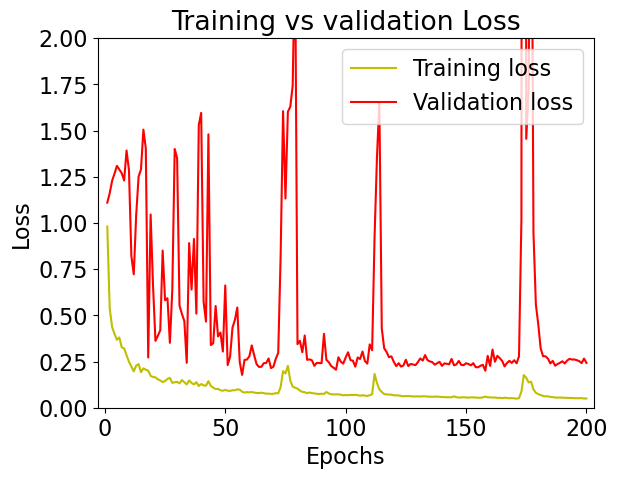

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'y', label="Training loss")
plt.plot(epochs, val_loss, 'r', label="Validation loss")
plt.title("Training vs validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xlim(-3, 203)
plt.ylim(0.0,2.0)
plt.legend()
plt.savefig('loss_graph_deeplabv3_aug_200epc_dropout30_6bch_'+time+'.png', dpi=600, format='png', bbox_inches='tight')
plt.show()

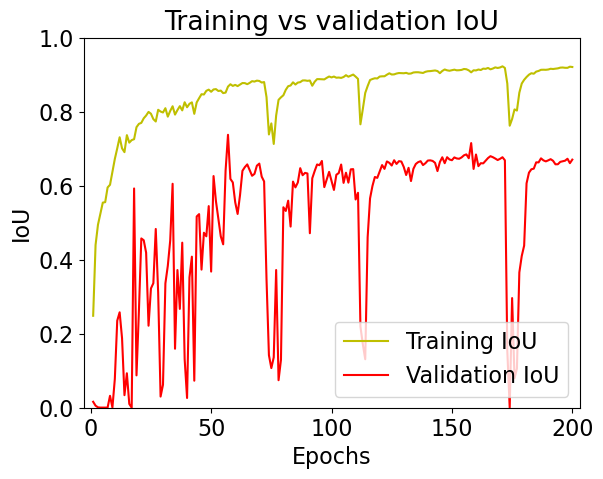

In [26]:
jc = history.history['iou_score']
val_jc= history.history['val_iou_score']
epochs = range(1, len(loss)+1)

plt.plot(epochs, jc, 'y', label="Training IoU")
plt.plot(epochs, val_jc, 'r', label="Validation IoU")
plt.title("Training vs validation IoU")
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.xlim(-3, 203)
plt.ylim(0.0,1)
plt.legend()
plt.savefig('metric_graph_deeplabv3_aug_200epc_dropout30_6bch_'+time+'.png', dpi=600, format='png', bbox_inches='tight')
plt.show()

In [27]:
del model
tf.keras.backend.clear_session()